# Lab 5 · Final Evaluation


## Team roster & submission links

The links below are read from `team.jsonl` and used for downloading each submission.

| Group | Members | Repo | Submission File |
|-------|---------|------|-----------------|
| 1 | Sameera, Tanmayi | [sameerashahh/CSE472-blanket-challenge](https://github.com/sameerashahh/CSE472-blanket-challenge/tree/project2_implementation) | [`final_project_implementation/submission.csv`](https://raw.githubusercontent.com/sameerashahh/CSE472-blanket-challenge/486287884d7099c273a570a16aec4d387f60320e/final_project_implementation/submission.csv) |
| 7 | Dhruv, Sahajpreet | [dhruvb26/CSE472-blanket-challenge](https://github.com/dhruvb26/CSE472-blanket-challenge/tree/main) | [`solution/runs/20251124_194116/submission.csv`](https://raw.githubusercontent.com/dhruvb26/CSE472-blanket-challenge/b8c8ca86d3f6d0aa97ba79cd1f6d73ca57018c50/solution/runs/20251124_194116/submission.csv) |
| 8 | Fredo, Anton | [saan-volta/CSE472-blanket-challenge-submission](https://github.com/saan-volta/CSE472-blanket-challenge-submission/tree/main) | [`submission/submission.csv`](https://raw.githubusercontent.com/saan-volta/CSE472-blanket-challenge-submission/942d6b74e42ec51330fdfc8505c992db356819cf/submission/submission.csv) |
| 10 | Ang, Muhammed | [muhammedhunaid/CSE472-blanket-challenge](https://github.com/muhammedhunaid/CSE472-blanket-challenge/tree/muhammed/final-submission) | [`submission.csv`](https://raw.githubusercontent.com/muhammedhunaid/CSE472-blanket-challenge/refs/heads/muhammed/final-submission/submission.csv) |


## Setup

Figures are written to `fig/`, cached submissions live in `data/`.


In [ ]:
%load_ext watermark
%watermark -a "Shu Wan" -v


%load_ext autoreload
%autoreload 2


Author: Shu Wan

Python implementation: CPython
Python version       : 3.12.0
IPython version      : 9.6.0



In [ ]:
from pathlib import Path

import httpx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import load_dataset
from dotenv import load_dotenv

from blanket.metrics import jaccard_score, rmse

load_dotenv()

sns.set_theme(style="whitegrid", context="talk")
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 8)

DATA_DIR = Path("data")
FIG_DIR = Path("fig")

for path in (DATA_DIR, FIG_DIR):
    path.mkdir(parents=True, exist_ok=True)

## Load ground-truth dataset

We keep the provided HF splits to double-check IDs, then convert the held-out test split to a Pandas frame with `y_test` and the Markov blanket mask.


In [ ]:
develop = load_dataset("CSE472-blanket-challenge/final-dataset", "develop", split="train")
submit = load_dataset("CSE472-blanket-challenge/final-dataset", "submit", split="train")
ground_truth_data = load_dataset("CSE472-blanket-challenge/final-ground-truth")

assert set(develop["data_id"]) == set(ground_truth_data["train"]["data_id"])
assert set(submit["data_id"]) == set(ground_truth_data["test"]["data_id"])

ground_truth = (
    ground_truth_data["test"]
    .select_columns(["data_id", "y_test", "feature_mask"])
    .rename_column("feature_mask", "markov_blanket")
    .to_pandas()
)

ground_truth.head()

,data_id,y_test,markov_blanket
0,data_199180bb,"[-0.715820487309831, -0.5229937472750307, -0.1...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, ..."
1,data_36d2b833,"[0.47789619643118164, 1.030159097667456, 0.721...","[1, 1, 1, 0, 0, 0, 0, 1, 0]"
2,data_e84cde01,"[-0.8836231861741721, 0.3569965503665673, -1.6...","[1, 1, 1, 0, 0, 1, 0, 0, 0]"
3,data_d4df06d1,"[-0.22188632225096155, -0.5354040505904503, 0....","[0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, ..."
4,data_645b0390,"[1.7953962802817207, 0.8358613711639618, 0.754...","[1, 1, 1, 0, 0, 1, 0, 0, 0]"


## Download & cache submissions

URLs come from `team.jsonl`. We skip downloads when the file already exists to keep runs fast and reproducible.


In [ ]:
def download_submission(url: str, save_path: Path, overwrite: bool = False) -> Path:
    if save_path.exists() and not overwrite:
        return save_path
    response = httpx.get(url, timeout=30.0)
    response.raise_for_status()
    save_path.write_bytes(response.content)
    return save_path

teams = load_dataset("json", data_files=str("team.jsonl"), split="train")

for team in teams:
    dest = DATA_DIR / f"team_{team['group']}_submission.csv"
    download_submission(team["submission_url"], dest)

sorted(DATA_DIR.iterdir())

[PosixPath('data/team_10_submission.csv'),
 PosixPath('data/team_1_submission.csv'),
 PosixPath('data/team_7_submission.csv'),
 PosixPath('data/team_8_submission.csv')]

## Load submissions into data frames

Parse the list-like columns into NumPy arrays and drop stray index columns if present.


In [ ]:
def to_array(value, dtype=float) -> np.ndarray:
    if isinstance(value, np.ndarray):
        return value.astype(dtype)
    if isinstance(value, list):
        return np.asarray(value, dtype=dtype)
    text = str(value).strip()
    if text.startswith("[") and text.endswith("]"):
        text = text[1:-1]
    return np.fromstring(text, sep=",", dtype=dtype)

submissions: dict[int, pd.DataFrame] = {}

for team in teams:
    group = team["group"]
    df = pd.read_csv(DATA_DIR / f"team_{group}_submission.csv")
    unnamed_cols = [c for c in df.columns if c.startswith("Unnamed:")]
    if unnamed_cols:
        df = df.drop(columns=unnamed_cols)
    df["y_pred"] = df["y_pred"].apply(lambda x: to_array(x, dtype=float))
    df["markov_blanket_pred"] = df["markov_blanket_pred"].apply(lambda x: to_array(x, dtype=int))
    submissions[group] = df

submissions[next(iter(submissions))].head()

,data_id,y_pred,markov_blanket_pred
0,data_199180bb,"[-0.8311597108840942, -0.057097531855106354, 0...","[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, ..."
1,data_36d2b833,"[0.728196382522583, 0.9574737548828125, 0.8013...","[1, 1, 1, 1, 1, 1, 1, 1, 0]"
2,data_e84cde01,"[-0.6710764765739441, -0.22597740590572357, -1...","[1, 1, 1, 1, 1, 1, 1, 1, 1]"
3,data_d4df06d1,"[0.04452061280608177, -0.039382219314575195, -...","[1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ..."
4,data_645b0390,"[1.1497278213500977, 0.6285420060157776, 1.104...","[1, 1, 1, 1, 1, 1, 1, 1, 1]"


## Validate submission format

Quick schema and shape checks to surface any mismatches before scoring.


In [ ]:
def validate_submission(submission: pd.DataFrame, ground_truth: pd.DataFrame, name: str) -> None:
    expected_columns = {"data_id", "y_pred", "markov_blanket_pred"}
    assert set(submission.columns) == expected_columns, f"{name}: column mismatch"
    assert set(submission["data_id"]) == set(ground_truth["data_id"]), f"{name}: data_id mismatch"
    assert submission.shape[0] == ground_truth.shape[0], f"{name}: row count mismatch"

    merged = submission.merge(ground_truth, on="data_id", how="inner")
    for _, row in merged.iterrows():
        assert len(row["y_pred"]) == len(row["y_test"]), f"{name}: y_pred length mismatch"
        assert len(row["markov_blanket_pred"]) == len(row["markov_blanket"]), f"{name}: mb length mismatch"
    print(f"✅ {name}: OK")

for group, df in submissions.items():
    validate_submission(df, ground_truth, name=f"Team {group}")

✅ Team 1: OK
✅ Team 7: OK
✅ Team 8: OK
✅ Team 10: OK


## Evaluate metrics

Score each task with RMSE and Jaccard, then combine them via `score = rmse × (1 - jaccard)`.


In [ ]:
def evaluate_task(y_true, y_pred, mb_true, mb_pred) -> dict:
    rmse_val = rmse(y_true, y_pred)
    jaccard_val = jaccard_score(mb_true, mb_pred)
    return {"rmse": rmse_val, "jaccard": jaccard_val, "score": rmse_val * (1 - jaccard_val)}

def evaluate_submission(submission: pd.DataFrame, ground_truth: pd.DataFrame) -> pd.DataFrame:
    merged = submission.merge(ground_truth, on="data_id", how="inner")
    results = []
    for _, row in merged.iterrows():
        res = evaluate_task(row["y_test"], row["y_pred"], row["markov_blanket"], row["markov_blanket_pred"])
        res["data_id"] = row["data_id"]
        results.append(res)
    return pd.DataFrame(results)

eval_results = {group: evaluate_submission(df, ground_truth) for group, df in submissions.items()}
eval_results[next(iter(eval_results))].head()

,rmse,jaccard,score,data_id
0,0.550203,0.615385,0.211617,data_199180bb
1,0.418071,0.500000,0.209035,data_36d2b833
2,0.558347,0.444444,0.310193,data_e84cde01
3,0.536927,0.294118,0.379007,data_d4df06d1
4,0.438907,0.444444,0.243837,data_645b0390


## Aggregate leaderboard

Compute per-team means and standard deviations for each metric, then sort by the final score.


In [ ]:
team_info = teams.to_pandas()
team_info["members"] = team_info["members"].apply(lambda x: ", ".join(x))

agg_rows = []
for group, df in eval_results.items():
    agg_rows.append(
        {
            "group": group,
            "rmse_mean": df["rmse"].mean(),
            "rmse_std": df["rmse"].std(),
            "jaccard_mean": df["jaccard"].mean(),
            "jaccard_std": df["jaccard"].std(),
            "score_mean": df["score"].mean(),
            "score_std": df["score"].std(),
        }
    )

agg_results_df = (
    pd.DataFrame(agg_rows)
    .merge(team_info[["group", "members"]], on="group", how="left")
    .sort_values(by="score_mean")
    .reset_index(drop=True)
)
agg_results_df.insert(0, "rank", range(1, len(agg_results_df) + 1))
agg_results_df


,rank,group,rmse_mean,rmse_std,...,jaccard_std,score_mean,score_std,members
0,1,10,0.559099,0.169822,...,0.332217,0.194036,0.253766,"Ang, Muhammed"
1,2,8,0.519179,0.134280,...,0.261667,0.208636,0.157782,"Fredo, Anton"
2,3,7,0.531110,0.135394,...,0.184637,0.280585,0.134703,"Dhruv, Sahajpreet"
3,4,1,0.524085,0.133272,...,0.190771,0.304475,0.136215,"Sameera, Tanmayi"


## Additional diagnostics

Build a long-form frame for task-level analysis and capture quick stats.


In [ ]:
score_df = pd.concat(
    [df.assign(group=group) for group, df in eval_results.items()],
    ignore_index=True,
)

corr_rmse_jaccard = score_df["rmse"].corr(score_df["jaccard"])
print(f"RMSE vs Jaccard correlation across tasks: {corr_rmse_jaccard:.3f}")
score_df.head()


RMSE vs Jaccard correlation across tasks: -0.287


,rmse,jaccard,score,data_id,group
0,0.550203,0.615385,0.211617,data_199180bb,1
1,0.418071,0.500000,0.209035,data_36d2b833,1
2,0.558347,0.444444,0.310193,data_e84cde01,1
3,0.536927,0.294118,0.379007,data_d4df06d1,1
4,0.438907,0.444444,0.243837,data_645b0390,1


## Metric summary plot

Bar plots of team-level means with standard deviation error bars. Figures are saved under `fig/`.


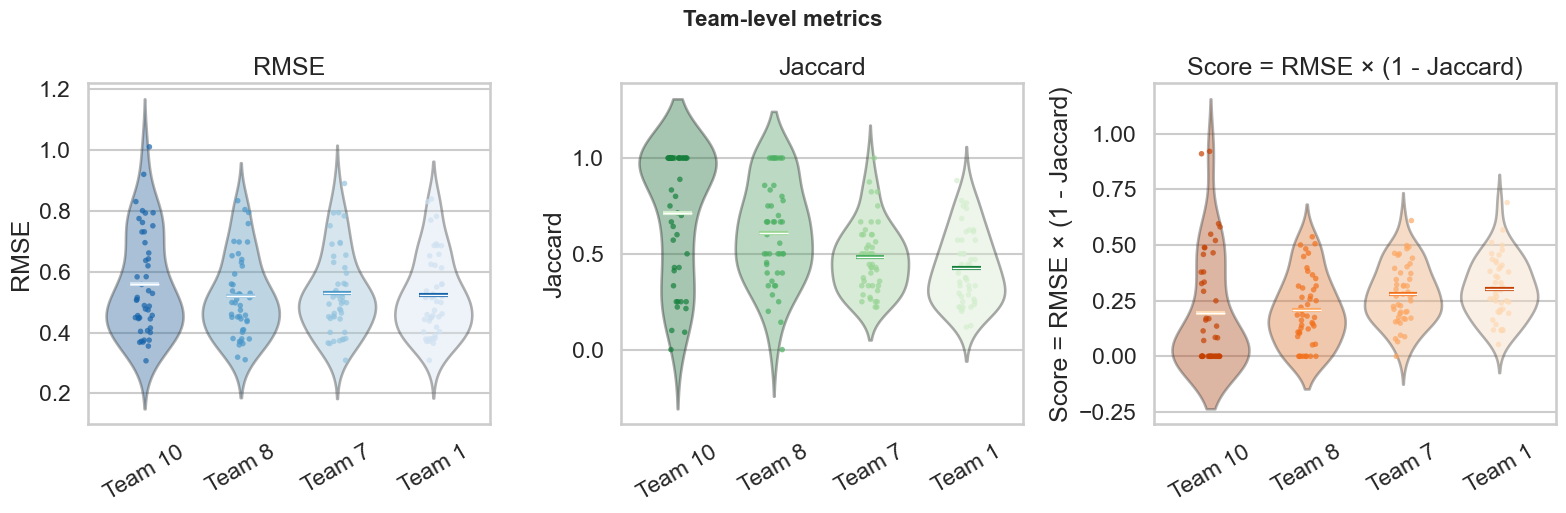

In [ ]:
plot_df = agg_results_df.copy()
plot_df["team_label"] = plot_df["group"].apply(lambda x: f"Team {x}")
team_order = plot_df["team_label"].tolist()

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
metrics = [
    ("rmse", "RMSE", "Blues"),
    ("jaccard", "Jaccard", "Greens"),
    ("score", "Score = RMSE × (1 - Jaccard)", "Oranges"),
]

score_df["team_label"] = score_df["group"].apply(lambda x: f"Team {x}")

for ax, (col, title, palette) in zip(axes, metrics):
    colors = sns.color_palette(palette, n_colors=len(team_order))
    sns.violinplot(data=score_df, x="team_label", y=col, order=team_order, hue="team_label",
                   palette=palette, inner=None, alpha=0.4, ax=ax, legend=False)
    sns.stripplot(data=score_df, x="team_label", y=col, order=team_order, hue="team_label",
                  palette=palette, size=4, alpha=0.7, ax=ax, legend=False)
    # Add mean markers with matching colors
    for i, team in enumerate(team_order):
        mean_val = score_df.loc[score_df["team_label"] == team, col].mean()
        ax.hlines(mean_val, i - 0.15, i + 0.15, color=colors[i], linewidth=3, zorder=10)
        ax.hlines(mean_val, i - 0.15, i + 0.15, color="white", linewidth=1, zorder=11)
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel(title)
    ax.tick_params(axis="x", rotation=30)

plt.tight_layout()
fig.suptitle("Team-level metrics", y=1.04, fontsize=16, fontweight="bold")
fig.savefig(FIG_DIR / "team_metric_summary.png", dpi=300, bbox_inches="tight")
plt.show()

## Trade-off & score distributions

- RMSE vs. Jaccard scatter shows the regression/feature-selection trade-off.
- Box plot shows score spread per team across tasks.


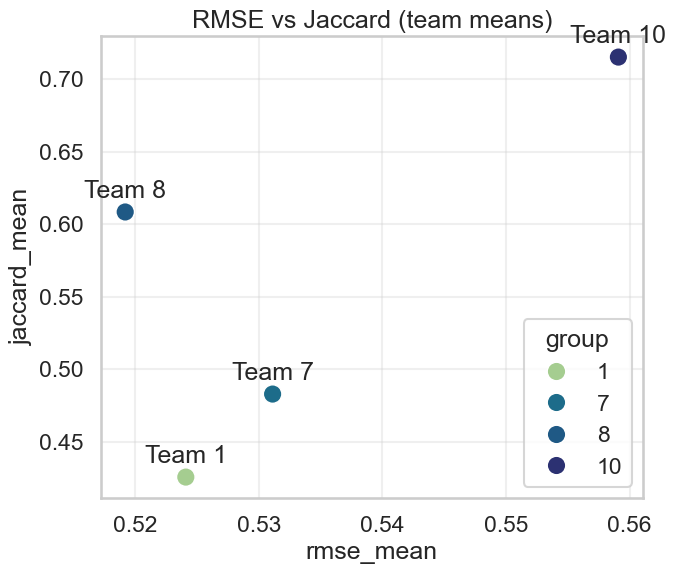

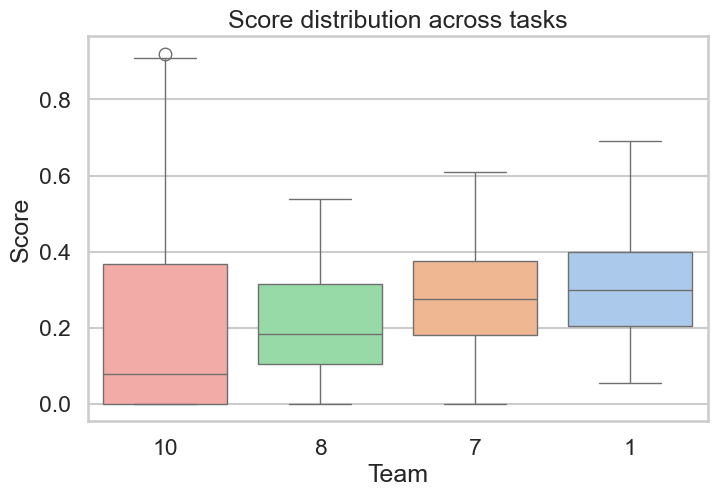

In [ ]:
scatter_order = agg_results_df["group"].tolist()

# RMSE vs Jaccard scatter
fig, ax = plt.subplots(figsize=(7, 6))
sns.scatterplot(data=agg_results_df, x="rmse_mean", y="jaccard_mean", hue="group", palette="crest", s=180, ax=ax)
for _, row in agg_results_df.iterrows():
    ax.text(row["rmse_mean"], row["jaccard_mean"] + 0.01, f"Team {row['group']}", ha="center")
ax.set_title("RMSE vs Jaccard (team means)")
ax.grid(True, alpha=0.3)
fig.savefig(FIG_DIR / "rmse_vs_jaccard.png", dpi=300, bbox_inches="tight")
plt.show()

# Score distribution per team
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(
    data=score_df,
    x="group",
    y="score",
    hue="group",
    order=scatter_order,
    palette="pastel",
    ax=ax,
    legend=False,
)
ax.set_title("Score distribution across tasks")
ax.set_xlabel("Team")
ax.set_ylabel("Score")
fig.savefig(FIG_DIR / "score_distribution_by_team.png", dpi=300, bbox_inches="tight")
plt.show()

## Task-wise wins

Count how many tasks each team wins (lowest score per task).


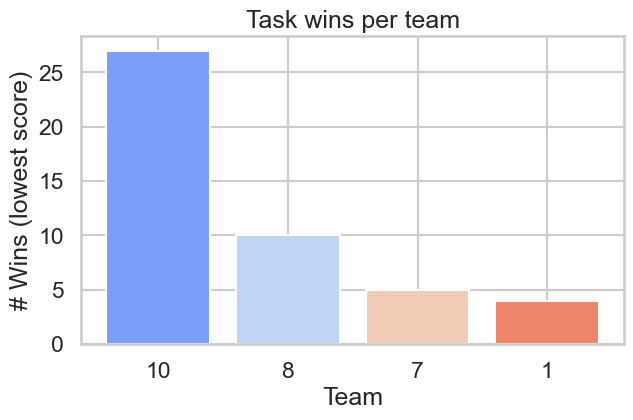

,group,wins
0,10,27
1,8,10
2,7,5
3,1,4


In [ ]:
task_winners = score_df.sort_values("score").groupby("data_id").first().reset_index()
win_counts = task_winners["group"].value_counts().reset_index()
win_counts.columns = ["group", "wins"]

fig, ax = plt.subplots(figsize=(7, 4))
ax.bar(win_counts["group"].astype(str), win_counts["wins"], color=sns.color_palette("coolwarm", n_colors=len(win_counts)))
ax.set_title("Task wins per team")
ax.set_xlabel("Team")
ax.set_ylabel("# Wins (lowest score)")
fig.savefig(FIG_DIR / "task_wins_by_team.png", dpi=300, bbox_inches="tight")
plt.show()

win_counts

## Quick takeaway

Highlight the current leader and a headline stat.


In [ ]:
leader = agg_results_df.iloc[0]
print(
    f"Leader: Team {leader.group} ({leader.members}) — score {leader.score_mean:.4f}, "
    f"RMSE {leader.rmse_mean:.3f}, Jaccard {leader.jaccard_mean:.3f}."
)
print(f"RMSE/Jaccard correlation across tasks: {corr_rmse_jaccard:.3f}")


Leader: Team 10 (Ang, Muhammed) — score 0.1940, RMSE 0.559, Jaccard 0.715.
RMSE/Jaccard correlation across tasks: -0.287
